In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from scipy import sparse
import re
import pickle
import os
from urllib.parse import urlparse, parse_qs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [0]:
df = pd.read_csv("/content/drive/My Drive/test_colab/df.csv")
df

In [0]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [0]:
df['length'] = df.url.str.len()
df['sharp'] = (df.url.str.count('#'))
df['equal'] = (df.url.str.count('='))
df['slash'] = ((df.url.str.count('/')) - 2)
df['dbleslash'] = (df.url.str.count('//')) - 1
df['question'] = (df.url.str.count('\?'))
df['com'] = (df.url.str.count('.com'))
df['dot'] = (df.url.str.count('\.'))
df['protocols'] = (df.url.str.count('https://') + df.url.str.count('http://'))
df['comma'] = (df.url.str.count('\,'))
tld = df.url.str.rpartition('.')[2]
tld = tld.str.replace('\/','')
subdomain = df.url.str.rpartition('.')[0]
subdomain = subdomain.str.rpartition('.')[2].str.replace('http://','').replace('https://','')
df['TLD'] = pd.DataFrame(tld.tolist(), index=df.index)
df['subdomain'] = pd.DataFrame(subdomain.tolist(), index=df.index)

In [0]:
def countdelim(url):
    count = 0
    delim = [';', '_', '?', '=', '&']
    for each in url:
        if each in delim:
            count = count + 1
    return count
    
def isPresentHyphen(url):
    return url.count('-')
    
def isPresentAt(url):
    return url.count('@')

def isPresentDSlash(url):
    return url.count('//')
    
def countSubDir(url):
    return url.count('/')
    
def get_ext(url):    
    root, ext = os.path.splitext(url)
    return ext
    
def countSubDomain(subdomain):
    if not subdomain:
        return 0
    else:
        return len(subdomain.split('.'))
    

df['count_hyphen'] = df['url'].apply(lambda row: isPresentHyphen(row))
df['count_DSlach'] = df['url'].apply(lambda row: isPresentDSlash(row))
df['count_SubDir'] = df['url'].apply(lambda row: countSubDir(row))
df['ext'] = df['url'].apply(lambda row: get_ext(row))
df['count_SubDomain'] = df['ext'].apply(lambda row: countSubDomain(row)) 
df['temp'] = df['url'].apply(lambda url: list(urlparse(url)))
columns = ['scheme', 'netloc', 'path', 'params', 'query', 'fragment']
df[columns] = pd.DataFrame(df.temp.values.tolist(), index=df.index)
df.drop('temp', axis=1, inplace=True)    

In [0]:
from sklearn import preprocessing

categorical = ['TLD', 'subdomain', 'ext', 'scheme', 'netloc', 'path', 'params', 'query', 'fragment'] 
for f in categorical:
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(df[f])
        df[f] = lbl.transform(df[f])

In [0]:
X = df[['length', 'sharp', 'equal', 'slash', 'dbleslash', 'question', 'com',\
        'dot', 'protocols', 'comma', 'count_hyphen', 'count_DSlach', 'count_SubDir',\
        'count_SubDomain','TLD', 'subdomain', 'ext', 'scheme', 'netloc', 'path', 'params', 'query', 'fragment'
       ]]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [9]:
## LogisticRegression
logreg = LogisticRegression().fit(X_train, y_train)
logreg_pred_y = logreg.predict(X_test)
print(classification_report(y_test, logreg_pred_y, target_names=['class 0', 'class 1']))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

     class 0       0.87      0.92      0.90     13490
     class 1       0.72      0.60      0.66      4510

    accuracy                           0.84     18000
   macro avg       0.80      0.76      0.78     18000
weighted avg       0.84      0.84      0.84     18000



In [0]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
recall_lr = cross_val_score(logreg, X_train, y_train, cv=10, scoring='recall')

In [11]:
## Multinomial Naive Bayes
model_mult = MultinomialNB().fit(X_train, y_train)
mult_pred_y = model_mult.predict(X_test)
print(classification_report(y_test, mult_pred_y, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.90      0.75      0.82     13490
     class 1       0.50      0.76      0.60      4510

    accuracy                           0.75     18000
   macro avg       0.70      0.75      0.71     18000
weighted avg       0.80      0.75      0.76     18000



In [0]:
recall_mnb = cross_val_score(model_mult, X_train, y_train, cv=10, scoring='recall')

In [13]:
## DT
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0).fit(X_train, y_train)
tree_pred_y = tree_model.predict(X_test)
print(classification_report(y_test, tree_pred_y, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.86      0.99      0.92     13490
     class 1       0.93      0.53      0.68      4510

    accuracy                           0.87     18000
   macro avg       0.90      0.76      0.80     18000
weighted avg       0.88      0.87      0.86     18000



In [0]:
recall_tr = cross_val_score(tree_model, X_train, y_train, cv=10, scoring='recall')

In [15]:
## RF
forest_model = RandomForestClassifier(n_estimators=5, random_state=2).fit(X_train, y_train)
forest_pred_y = forest_model.predict(X_test)
print(classification_report(y_test, forest_pred_y, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.96      0.97      0.96     13490
     class 1       0.91      0.87      0.89      4510

    accuracy                           0.95     18000
   macro avg       0.93      0.92      0.93     18000
weighted avg       0.95      0.95      0.95     18000



In [0]:
recall_fr = cross_val_score(forest_model, X_train, y_train, cv=10, scoring='recall')

In [17]:
## gradient Boosting
model_grad = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=0).fit(X_train, y_train)
grad_pred_y = model_grad.predict(X_test)
print(classification_report(y_test, grad_pred_y, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.93      0.97      0.95     13490
     class 1       0.90      0.78      0.83      4510

    accuracy                           0.92     18000
   macro avg       0.91      0.87      0.89     18000
weighted avg       0.92      0.92      0.92     18000



In [0]:
recall_gb = cross_val_score(model_grad, X_train, y_train, cv=10, scoring='recall')

In [19]:
## XGBoost
model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=1, random_state=0).fit(X_train, y_train)
xgb_pred_y = model_xgb.predict(X_test)
print(classification_report(y_test, xgb_pred_y, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.91      0.98      0.94     13490
     class 1       0.90      0.69      0.79      4510

    accuracy                           0.90     18000
   macro avg       0.90      0.83      0.86     18000
weighted avg       0.90      0.90      0.90     18000



In [0]:
recall_xgb = cross_val_score(model_xgb, X_train, y_train, cv=10, scoring='recall')

In [21]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

## Support Vector Classifier + Bagging
estimator = LinearSVC()
n_estimators = 10
n_jobs = 1
model = BaggingClassifier(base_estimator=estimator,
                          n_estimators=n_estimators,
                          max_samples=1./n_estimators,
                          n_jobs=n_jobs).fit(X_train, y_train)
svc_pred_y = model.predict(X_test)
print(classification_report(y_test, svc_pred_y, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.83      0.95      0.89     13490
     class 1       0.74      0.42      0.54      4510

    accuracy                           0.82     18000
   macro avg       0.79      0.69      0.71     18000
weighted avg       0.81      0.82      0.80     18000



In [0]:
recall_svc = cross_val_score(model, X_train, y_train, cv=10, scoring='recall')


In [33]:
recall_lr, recall_mnb, recall_tr, recall_fr, recall_gb, recall_xgb, recall_svc

(array([0.60438513, 0.60819828, 0.55672069, 0.61010486, 0.65681602,
        0.62535748, 0.60343184, 0.60629171, 0.58627264, 0.62917064]),
 array([0.74833174, 0.7521449 , 0.75500477, 0.73784557, 0.74928503,
        0.74642517, 0.7435653 , 0.73975214, 0.76549094, 0.75023832]),
 array([0.52716873, 0.53670162, 0.54242135, 0.50333651, 0.55958055,
        0.53479504, 0.51668255, 0.48617731, 0.56244042, 0.52812202]),
 array([0.86558627, 0.83889418, 0.8465205 , 0.83984747, 0.86749285,
        0.85795996, 0.86081983, 0.83889418, 0.85224023, 0.87511916]),
 array([0.76835081, 0.76167779, 0.75977121, 0.77121068, 0.77883699,
        0.78551001, 0.77693041, 0.75023832, 0.77025739, 0.78169685]),
 array([0.6577693 , 0.68446139, 0.67874166, 0.66539561, 0.69780744,
        0.68922784, 0.68160153, 0.66730219, 0.66253575, 0.68922784]),
 array([0.65681602, 0.58627264, 0.60629171, 0.6920877 , 0.521449  ,
        0.64156339, 0.42802669, 0.43279314, 0.3593899 , 0.56339371]))

In [0]:
recall = pd.DataFrame({'LogisticRegression' : recall_lr, 'Multinomial Naive Bayes' : recall_mnb, 'Decision tree' : recall_tr, 'Random Forest' : recall_fr, 'Gradient Boosting' : recall_gb, 'XGBooster' : recall_xgb, 'SVC' : recall_svc    })

In [0]:
# recall.to_csv('/content/drive/My Drive/test_colab/model_recall_score.csv')

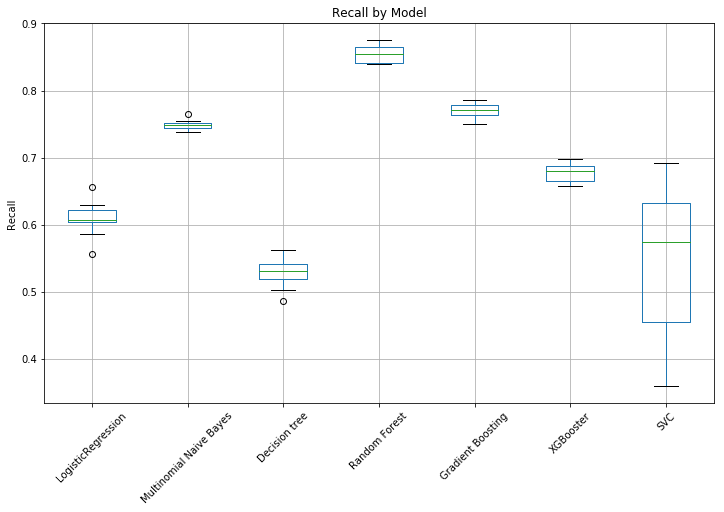

In [35]:
## boxplot
plt.figure(figsize=(12, 7))
recall.boxplot(column= ['LogisticRegression', 'Multinomial Naive Bayes', 'Decision tree', 'Random Forest', 'Gradient Boosting', 'XGBooster', 'SVC']) 
plt.xticks(size = 10, rotation=45)
plt.yticks(size = 10)
plt.title('Recall by Model')
plt.ylabel("Recall")
plt.show()